### Step 1: Import Required Libraries

In [21]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna

### Step 2: Define Environment

In [22]:
class IbuprofenEnv(gym.Env):
    def __init__(self):
        super(IbuprofenEnv, self).__init__()
        # Action space: 0 (No dose), 1 (200 mg), ..., 4 (800 mg)
        self.action_space = gym.spaces.Discrete(5)
        # State space: plasma concentration (mg/L)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)

        # Pharmacokinetics
        self.therapeutic_range = (10, 50)  # Therapeutic range (mg/L)
        self.half_life = 2.0  # Plasma half-life in hours
        self.clearance_rate = 0.693 / self.half_life  # First-order decay rate constant
        self.time_step_hours = 6  # Time step duration in hours

        # Simulation settings
        self.max_steps = 24  # 24 steps = 6-hour intervals over 6 days
        self.current_step = 0
        self.plasma_concentration = 0.0

    def reset(self):
        self.current_step = 0
        self.plasma_concentration = 0.0
        return np.array([self.plasma_concentration], dtype=np.float32)

    def step(self, action):
        # Dosage based on action
        dose_mg = action * 200  # Convert action index to dose (mg)
        absorbed = dose_mg / 10  # Assume 10% bioavailability (simplified)
        self.plasma_concentration += absorbed

        # Clearance: Exponential decay over time
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)

        # Reward based on plasma concentration
        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            reward = 10  # Within therapeutic range
        elif self.plasma_concentration > 100:  # Toxic concentration
            reward = -20  # Severe penalty for toxicity
        elif self.plasma_concentration < self.therapeutic_range[0]:
            reward = -5  # Subtherapeutic
        else:
            reward = -10  # Above therapeutic but below toxic

        # Update simulation state
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return np.array([self.plasma_concentration], dtype=np.float32), reward, done, {}

### Step 3: Define Policy and Value Networks

In [23]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.fc(state)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.fc(state)

### Step 4: Define PPO Agent

In [24]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.0001, gamma=0.95, eps_clip=0.15):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.value = ValueNetwork(state_dim)
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=lr)
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip

    def compute_advantage(self, rewards, values, dones):
        advantage = []
        g_t = 0
        for reward, value, done in zip(reversed(rewards), reversed(values), reversed(dones)):
            g_t = reward + self.gamma * g_t * (1 - done)
            advantage.insert(0, g_t - value)
        return advantage

    def train(self, states, actions, rewards, dones, old_probs):
        # Convert lists to numpy arrays for efficient tensor conversion
        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int64)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)
        old_probs = np.array(old_probs, dtype=np.float32)
    
        # Convert numpy arrays to PyTorch tensors
        states = torch.tensor(states)
        actions = torch.tensor(actions)
        rewards = torch.tensor(rewards)
        dones = torch.tensor(dones)
        old_probs = torch.tensor(old_probs)
    
        values = self.value(states).squeeze()
        advantages = self.compute_advantage(rewards, values.detach().numpy(), dones.numpy())
        advantages = torch.tensor(advantages, dtype=torch.float32)
    
        for _ in range(5):  # PPO multiple updates
            new_probs = self.policy(states).gather(1, actions.unsqueeze(1)).squeeze()
            ratio = (new_probs / old_probs)
            clip = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip)
            policy_loss = -torch.min(ratio * advantages, clip * advantages).mean()
    
            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()
    
        value_loss = nn.MSELoss()(self.value(states).squeeze(), rewards)
        self.optimizer_value.zero_grad()
        value_loss.backward()
        self.optimizer_value.step()


### Step 5: Optimization of Hyperparameters

In [25]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # Learning rate
    gamma = trial.suggest_float('gamma', 0.9, 0.99)  # Discount factor
    eps_clip = trial.suggest_float('eps_clip', 0.1, 0.3)  # Clipping parameter

    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, lr=lr, gamma=gamma, eps_clip=eps_clip)
    reward_history = []

    for episode in range(50):  # Use fewer episodes for faster tuning
        state = env.reset()
        states, actions, rewards, dones, old_probs = [], [], [], [], []
        total_reward = 0

        while True:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = agent.policy(state_tensor).detach().numpy()
            action = np.random.choice(env.action_space.n, p=action_probs)

            new_state, reward, done, _ = env.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            old_probs.append(action_probs[action])

            state = new_state
            total_reward += reward
            if done:
                break

        agent.train(states, actions, rewards, dones, old_probs)
        reward_history.append(total_reward)

    return np.mean(reward_history)


### Step 6: Perform Optimization

In [26]:
env = IbuprofenEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

[I 2024-11-26 18:55:51,518] A new study created in memory with name: no-name-6a515953-dc40-48ef-a5a8-015a200fc324
[I 2024-11-26 18:55:52,159] Trial 0 finished with value: 34.2 and parameters: {'lr': 0.00010080730205701601, 'gamma': 0.919469006429285, 'eps_clip': 0.16152102683870498}. Best is trial 0 with value: 34.2.
[I 2024-11-26 18:55:53,255] Trial 1 finished with value: -91.2 and parameters: {'lr': 3.7109985592472985e-05, 'gamma': 0.9115074006220909, 'eps_clip': 0.2473192094196879}. Best is trial 0 with value: 34.2.
[I 2024-11-26 18:55:54,057] Trial 2 finished with value: 138.0 and parameters: {'lr': 0.00035384971729786536, 'gamma': 0.9128730211386152, 'eps_clip': 0.19587594129235858}. Best is trial 2 with value: 138.0.
[I 2024-11-26 18:55:54,957] Trial 3 finished with value: 51.9 and parameters: {'lr': 0.00010166094936848599, 'gamma': 0.9810270497196536, 'eps_clip': 0.12493320929629284}. Best is trial 2 with value: 138.0.
[I 2024-11-26 18:55:55,439] Trial 4 finished with value: 208

Best hyperparameters: {'lr': 0.0010329127957819902, 'gamma': 0.9351155958624873, 'eps_clip': 0.2509109336863127}


### Step 7: Train the agent with best hyperparameters

In [27]:
best_params = study.best_params
agent = PPOAgent(state_dim=state_dim, action_dim=action_dim,
                 lr=best_params['lr'],
                 gamma=best_params['gamma'],
                 eps_clip=best_params['eps_clip'])

episodes = 1000
reward_history = []

for episode in range(episodes):
    state = env.reset()
    states, actions, rewards, dones, old_probs = [], [], [], [], []
    total_reward = 0

    while True:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = agent.policy(state_tensor).detach().numpy()
        action = np.random.choice(env.action_space.n, p=action_probs)

        new_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        old_probs.append(action_probs[action])

        state = new_state
        total_reward += reward
        if done:
            break

    agent.train(states, actions, rewards, dones, old_probs)
    reward_history.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")


Episode 1: Total Reward = -120
Episode 2: Total Reward = -60
Episode 3: Total Reward = -30
Episode 4: Total Reward = -60
Episode 5: Total Reward = -30
Episode 6: Total Reward = 60
Episode 7: Total Reward = 75
Episode 8: Total Reward = 135
Episode 9: Total Reward = 210
Episode 10: Total Reward = 225
Episode 11: Total Reward = 240
Episode 12: Total Reward = 225
Episode 13: Total Reward = 225
Episode 14: Total Reward = 225
Episode 15: Total Reward = 225
Episode 16: Total Reward = 240
Episode 17: Total Reward = 240
Episode 18: Total Reward = 240
Episode 19: Total Reward = 180
Episode 20: Total Reward = 225
Episode 21: Total Reward = 225
Episode 22: Total Reward = 225
Episode 23: Total Reward = 225
Episode 24: Total Reward = 240
Episode 25: Total Reward = 210
Episode 26: Total Reward = 225
Episode 27: Total Reward = 240
Episode 28: Total Reward = 225
Episode 29: Total Reward = 225
Episode 30: Total Reward = 240
Episode 31: Total Reward = 225
Episode 32: Total Reward = 210
Episode 33: Total 

### Step 8: Plot training and evaluation results

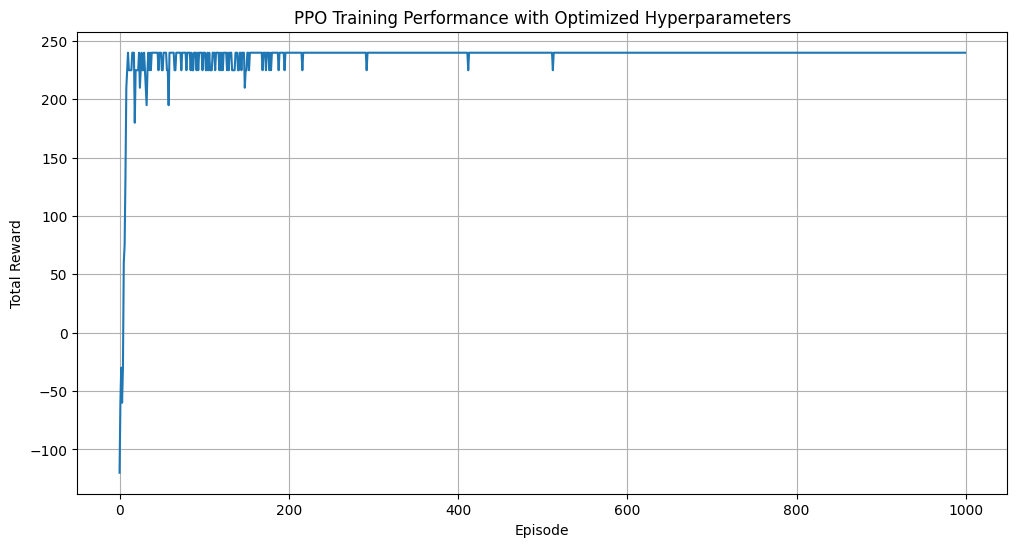

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Training Performance with Optimized Hyperparameters')
plt.grid()
plt.show()


### Step 9: Evaluation 

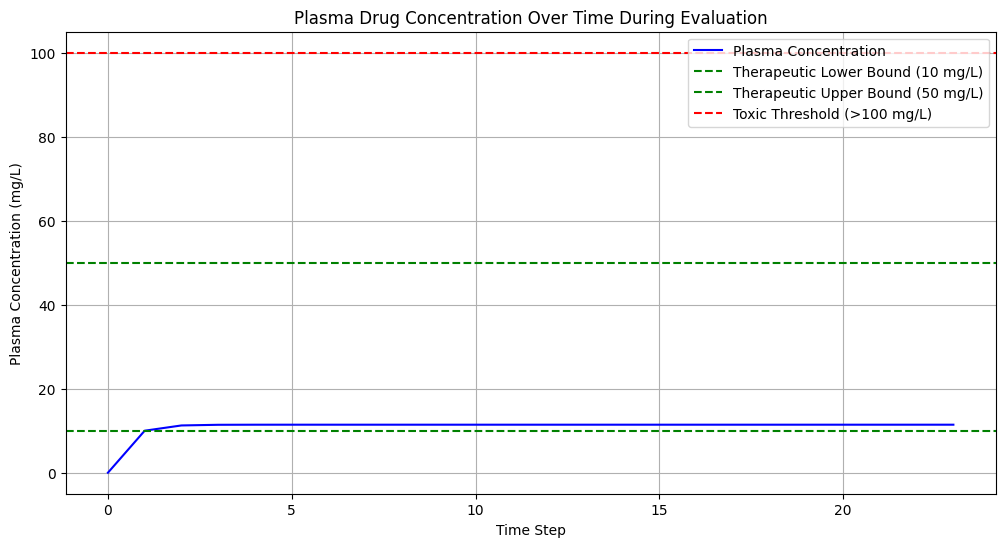

In [29]:
# Evaluation phase
state_trajectory = []
state = env.reset()
done = False

while not done:
    state_trajectory.append(state[0])  # Record plasma concentration
    state_tensor = torch.tensor(state, dtype=torch.float32)
    action = agent.policy(state_tensor).argmax().item()
    state, reward, done, _ = env.step(action)

plt.figure(figsize=(12, 6))
plt.plot(range(len(state_trajectory)), state_trajectory, label='Plasma Concentration', color='b')
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')
plt.xlabel('Time Step')
plt.ylabel('Plasma Concentration (mg/L)')
plt.title('Plasma Drug Concentration Over Time During Evaluation')
plt.legend()
plt.grid()
plt.show()


### Step 10: Visualize Optuna Results

In [30]:
optuna.visualization.plot_optimization_history(study).show()


In [31]:
optuna.visualization.plot_param_importances(study).show()